# Preprocessing of dMRI data

This preprocessing is based on Wiktor's work with dMRI data. A specific file is taken as an example.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import nibabel as nib
from os import listdir
from os.path import isfile, join
from scipy import signal

In [2]:
# current path
cur_path = os.getcwd()
# file name and path
file = "BB_003_3T_cmrr_mbep2d_diff_0pt2_1_task_18s_off_12s_on_20200710180104_8"
file_name = "/".join(cur_path.split("/")[:-1]) + "/analyses_output/"+str(file)+"/dfMRI_raw.nii.gz"
# loading nifti object/header
raw_data_ = nib.load(file_name)
header  = raw_data_.header
raw_data = raw_data_.get_fdata()

In [3]:
header.get_xyzt_units()

('mm', 'sec')

In [4]:
raw_data.shape

(116, 116, 14, 600)

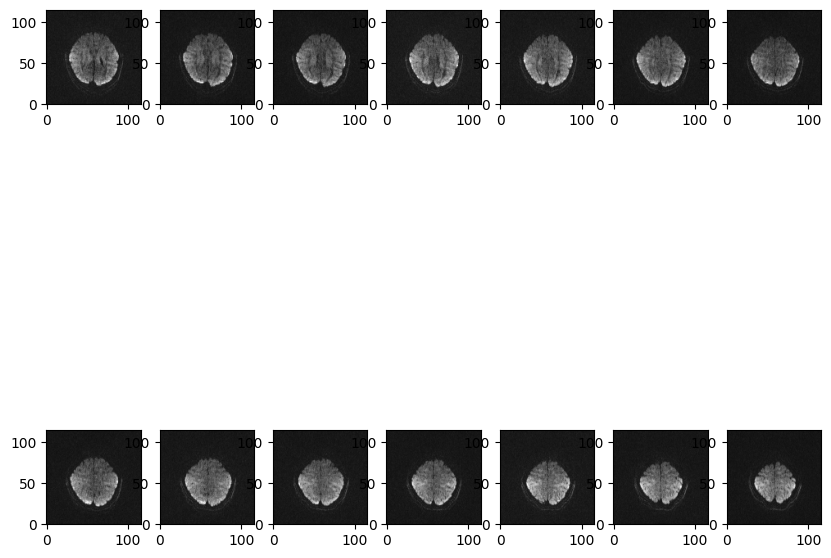

In [5]:
# print all slices wrt z axis after defining a random time 
slices = []
time = 15
for s in range(raw_data.shape[2]):
    z_slice = raw_data[:, :, s,time]
    slices.append(z_slice)
            
nrows = 2
ncols=int(len(slices)/nrows)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10, 10))
ii = 0
for i, slice in enumerate(slices):
    row = int(ii/ncols)
    col = ii%ncols
    ax[row][col].imshow(slice.T, cmap="gray", origin="lower")
    ii = ii + 1

# Getting rid of the first volumes

1st volume for some scans has to be removed as sometimes it has another b-value than the remaining volumes (we wanted to cover different b-values - calibration issues)


In [7]:
No_dummies_out = 0

In [8]:
dfMRI_raw  = raw_data[:,:,:,No_dummies_out:]

In [9]:
No_volumes = raw_data.shape[3]

In [10]:
dfMRI_raw.shape

(116, 116, 14, 600)

# Identifying volume outliers and removing them

In [11]:
if "diff" in file_name:
    # if it is diffusion data
    make_adc = True
else :
    # BOLD 
    make_adc = False

In [12]:
# compress into 2D
dfMRI_raw_2D = dfMRI_raw.reshape(dfMRI_raw.shape[0]*dfMRI_raw.shape[1]*dfMRI_raw.shape[2], dfMRI_raw.shape[3])

In [13]:
dfMRI_raw_2D.shape

(188384, 600)

In [14]:
# mean over the volume
mean_dfMRI_raw_2D = np.mean(dfMRI_raw_2D, axis = 0)

In [15]:
mean_dfMRI_raw_2D.shape

(600,)

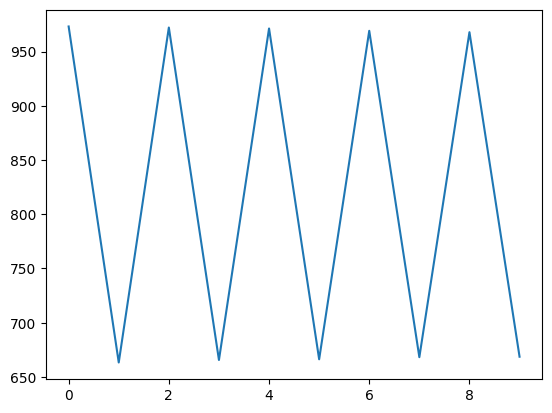

In [16]:
plt.plot(mean_dfMRI_raw_2D[:10])

This shows that there are 2 different b values in the data that need to be separated

In [17]:
if make_adc:
    # separate b values
    b1_times = np.arange(0, len(mean_dfMRI_raw_2D),2)
    b2_times = np.arange(1, len(mean_dfMRI_raw_2D),2)
    b1_mean_dfMRI = mean_dfMRI_raw_2D[b1_times]
    b2_mean_dfMRI = mean_dfMRI_raw_2D[b2_times]
    
    # detrend for movement correction
    b1_mean_dfMRI_det= signal.detrend(b1_mean_dfMRI) - np.mean(signal.detrend(b1_mean_dfMRI)) + np.mean(b1_mean_dfMRI);
    b2_mean_dfMRI_det= signal.detrend(b2_mean_dfMRI) - np.mean(signal.detrend(b2_mean_dfMRI)) + np.mean(b2_mean_dfMRI);
   

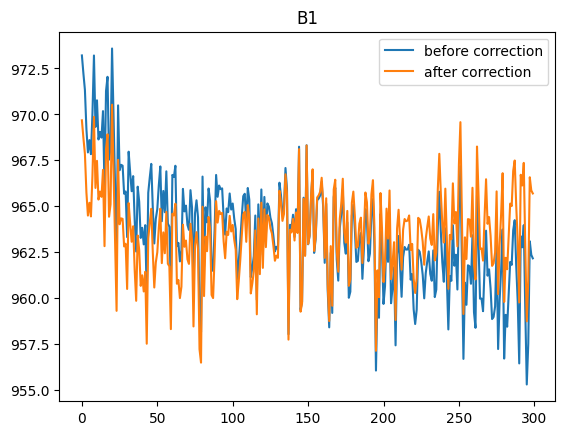

In [18]:
plt.plot(b1_mean_dfMRI, label = "before correction")
plt.plot(b1_mean_dfMRI_det, label = "after correction")
plt.title("B1")
plt.legend()

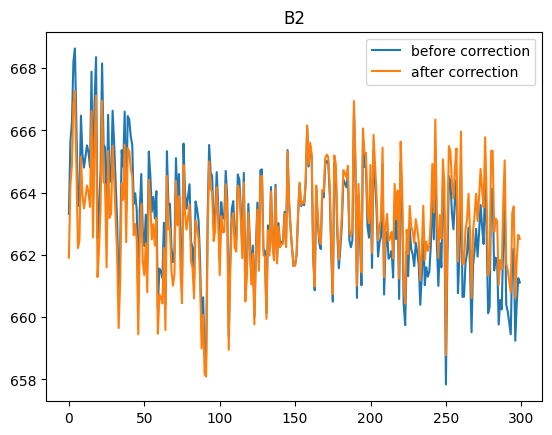

In [19]:
plt.plot(b2_mean_dfMRI, label = "before correction")
plt.plot(b2_mean_dfMRI_det, label = "after correction")
plt.title("B2")
plt.legend()

In [20]:
vol_outliers_thr = 0.01

In [21]:
# Discard outliers (if any)
b1_mean_dfMRI_outliers = b1_mean_dfMRI_det.copy()
med = np.median(b1_mean_dfMRI_outliers)
b1_vol_outliers = np.where(abs(b1_mean_dfMRI_outliers- med) > vol_outliers_thr*med)
#b1_mean_dfMRI_wo_outliers = b1_mean_dfMRI_outliers.copy()
#b1_mean_dfMRI_wo_outliers[b1_vol_outliers] = np.nan

b2_mean_dfMRI_outliers = b2_mean_dfMRI_det.copy()
med = np.median(b2_mean_dfMRI_outliers)
b2_vol_outliers = np.where(abs(b2_mean_dfMRI_outliers- med) > vol_outliers_thr*med)
#b2_mean_dfMRI_wo_outliers = b2_mean_dfMRI_outliers.copy()
#b2_mean_dfMRI_wo_outliers[b2_vol_outliers] = np.nan

In [22]:
del  b1_mean_dfMRI, b2_mean_dfMRI, b1_mean_dfMRI_det, b2_mean_dfMRI_det

In [23]:
dfmri = raw_data
for i in b1_times[b1_vol_outliers]:
    dfmri[:,:,:,i] = np.nan
for i in b2_times[b2_vol_outliers]:
    dfmri[:,:,:,i] = np.nan


In [24]:
del b1_vol_outliers, b2_vol_outliers

In [25]:
img = nib.Nifti1Image(dfmri, np.eye(4))

In [26]:
dfmri.shape

(116, 116, 14, 600)

In [27]:
nib.save(img, 'test_part1.nii.gz')  

# PCA denoising

Open terminal in the right folder and run :

dwidenoise test_part1.nii.gz test_part2.nii.gz -noise noise.nii.gz -extent 9 -force

In [28]:
file_name = cur_path + "/test_part2.nii.gz"
# loading nifti object
pca_dfmri = nib.load(file_name)
pca_dfmri = pca_dfmri.get_fdata()

EOFError: Compressed file ended before the end-of-stream marker was reached

In [ ]:
file_name = cur_path + "/noise.nii.gz"
# loading nifti object
noise = nib.load(file_name)
noise = noise.get_fdata()

In [ ]:
# print all slices wrt z axis after defining a random time 
slices = []
time = 15
for s in range(pca_dfmri.shape[2]):
    z_slice = pca_dfmri[:, :, s,time]
    slices.append(z_slice)
            
nrows = 2
ncols=int(len(slices)/nrows)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10, 10))
ii = 0
for i, slice in enumerate(slices):
    row = int(ii/ncols)
    col = ii%ncols
    ax[row][col].imshow(slice.T, cmap="gray", origin="lower")
    ii = ii + 1

In [30]:
noise.shape

(116, 116, 14)

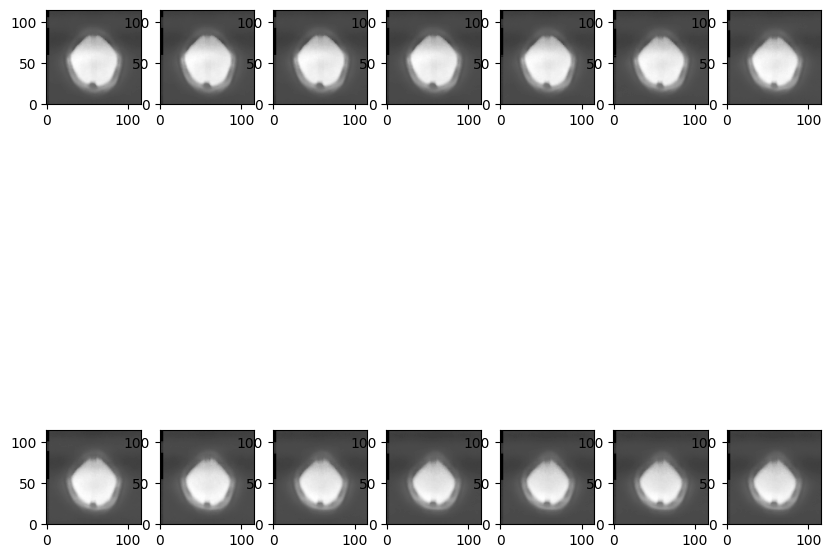

In [31]:
# print all slices wrt z axis after defining a random time 
         
nrows = 2
ncols=int(len(slices)/nrows)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10, 10))
ii = 0
for i in range(noise.shape[2]):
    slice = noise[:,:,i]
    row = int(ii/ncols)
    col = ii%ncols
    ax[row][col].imshow(slice.T, cmap="gray", origin="lower")
    ii = ii + 1